In [47]:
'''
dataloader for road kill image
14 Nov 2022
Livie
Yumeng Li
'''
import os
import numpy as np
import cv2
import json
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, target_type = 'poly'):
        self.image_dir = './data/public-images'
        self.annotation_dir = './data/public-annotation'
        # # load folder file list
        self.image_ls = os.listdir(self.image_dir)
        self.annotation_ls = os.listdir(self.annotation_dir)
        # set size for images(not all images have the same size)
        self.img_dim = (1280, 960)
        self.target_type = target_type
    def __len__(self):
        return len(self.annotation_ls)

    def convert_box(self, file, type="bb"):
        ## eg. file = vlcsnap-2021-06-06-20h10m22s280.json
        path_json = os.path.join(self.annotation_dir, file)
        image_file = file.replace(".json",".jpeg")
        img = cv2.imread(os.path.join(self.image_dir, image_file))
        try:
                with open(path_json) as json_file:
                        data = json.load(json_file)
                if data["annotations"] == []:
                        bm = np.zeros(img.shape[0:2])
                        print('null:',path_json)
                else:       
                        box = data["annotations"][0]["bounding_box"]
                        x,y,w,h = int(box["x"]),int(box["y"]),int(box["w"]),int(box["h"])
                        bm = np.zeros(img.shape[0:2])
                        bm[y:y+h,x:x+w] = 1
        except:
                print(path_json)
        return img, bm

    def convert_polygon(self, file, type="bb"):
        ## eg. file = vlcsnap-2021-06-06-20h10m22s280.json
        path_json = os.path.join(self.annotation_dir, file)
        image_file = file.replace(".json",".jpeg")
        img = cv2.imread(os.path.join(self.image_dir, image_file))
        try:
                with open(path_json) as json_file:
                        data = json.load(json_file)
                if data["annotations"] == []:
                        mask = np.zeros(img.shape[:2], dtype="uint8")
                        # bm = np.int8(bm)
                        print('null:',path_json)
                else:       
                        mask = np.zeros(img.shape[:2], dtype="uint8")
                        pts = data["annotations"][0]["polygon"]["path"]
                        pts = np.array([[pt["x"],pt["y"]] for pt in pts],dtype=np.int32)
                        cv2.fillPoly(mask, pts =[pts], color=(255,0,0))
                        # target = cv2.bitwise_and(img, img, mask=mask)
                        # plt.imshow(target)
                        
                # np.savetxt(os.path.join(target_folder, txt_file), bm, fmt = '%s')
        except:
                print(path_json)
        return img, mask

        
    def __getitem__(self, idx):
        tgt_name = self.annotation_ls[idx]
        if self.target_type == 'box':
                img,tgt = self.convert_box(tgt_name)
        elif self.target_type == 'poly':
                img,tgt = self.convert_polygon(tgt_name)
        else:
                raise Exception('wrong type')
        # get label and filename from the loaded dataframe
        img = cv2.resize(img, self.img_dim, interpolation = cv2.INTER_AREA)
        tgt = cv2.resize(tgt, self.img_dim, interpolation = cv2.INTER_AREA)[:,:,np.newaxis]
        img_tensor = torch.from_numpy(img)[:,:,[2,1,0]]
        # img_tensor = img_tensor.permute(2, 0, 1)
        # create sensor for label
        tgt_tensor = torch.from_numpy(tgt)
        # tgt_tensor = tgt_tensor.permute(2, 0, 1)
        return img_tensor, tgt_tensor



Batch of images has shape:  torch.Size([10, 960, 1280, 3])
Batch of labels has shape:  torch.Size([10, 960, 1280, 1])


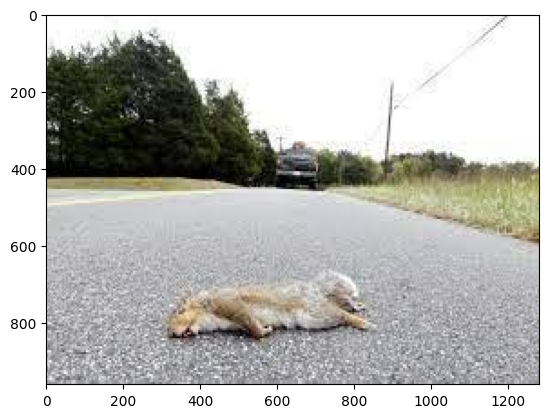

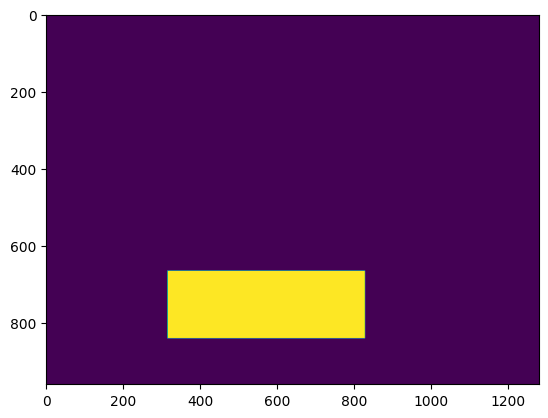

In [49]:
if __name__ == "__main__":
    dataset = CustomDataset(target_type = 'box')
    print(dataset)
    data_loader = DataLoader(dataset, batch_size=10, shuffle=True)
    for img, label in data_loader:
        plt1 = plt.figure()
        plt1 = plt.imshow(img[0,:,:,:])
        plt2 = plt.figure()
        plt2 = plt.imshow(label[0,:,:,0])
        print("Batch of images has shape: ",img.shape)
        print("Batch of labels has shape: ", label.shape)
        break